In [1]:
using Multilane
using POMDPs
using POMDPToolbox
using MCTS
using Distributions # for Normal
using DataArrays
using DataFrames
using DataFramesMeta

using ParticleFilters
using BasicPOMCP
#using Interact
using Interact
using Reactive
#using Records
using AutoViz
using AutomotiveDrivingModels
using JLD
#using Cairo
#using Reel
#using GenerativeModels

In [2]:
#Set up problem configuration
nb_lanes = 4
pp = PhysicalParam(nb_lanes,lane_length=100.) #2.=>col_length=8
_discount = 0.9
nb_cars=10

#rmodel = NoCrashRewardModel()
rmodel  = NoCrashRewardModel(100.,10.,2.5,4,1.,1,2500,3000)

be = standard_uniform()
dmodel = NoCrashIDMMOBILModel(nb_cars, pp, behaviors = be)
#dmodel = NoCrashIDMMOBILModel(nb_cars, pp)

mdp = NoCrashMDP{NoCrashRewardModel}(dmodel, rmodel, _discount)
pomdp = NoCrashPOMDP{NoCrashRewardModel}(dmodel, rmodel, _discount)

rng = MersenneTwister(5);

  likely near In[2]:11
  likely near In[2]:11
  likely near In[2]:11
  likely near In[2]:11


In [28]:
is = relaxed_initial_state(mdp);

simulate done


In [4]:
nb_sims = 500;
p_resample_noise = 0.1;
resample_noise_factor = 10;
params = WeightUpdateParams(0.02,0.01);

updater = AggressivenessUpdater(mdp,
                           nb_sims,
                           p_resample_noise,
                           resample_noise_factor,
                           params,
                           rng);

In [5]:
solver = MLMPCSolver(DPWSolver(depth=20,
                    exploration_constant=5.0,
                    n_iterations=500),updater);

In [6]:
agent = solve(solver,mdp);

In [23]:
agent3 = deepcopy(agent);

In [20]:
agent2 = deepcopy(agent);

In [24]:
agent3 == agent2

false

In [29]:
is.x = 0;
is.t = 0;
steps = 200;
sim = relaxed_initial_state_cz(mdp,is,agent,steps);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] max(::Array{Float64,1}, ::Float64) at ./deprecated.jl:57
 [3] update(::Multilane.AggressivenessUpdater, ::Multilane.AggressivenessBelief, ::Multilane.MLAction, ::Multilane.MLPhysicalState, ::Multilane.AggressivenessBelief) at /home/zhong/.julia/v0.6/Multilane/src/aggressiveness_particle_filter.jl:150
 [4] update(::Multilane.AggressivenessUpdater, ::Multilane.AggressivenessBelief, ::Multilane.MLAction, ::Multilane.MLPhysicalState) at /home/zhong/.julia/v0.6/Multilane/src/aggressiveness_particle_filter.jl:149
 [5] action(::Multilane.MLMPCAgent, ::Multilane.MLState) at /home/zhong/.julia/v0.6/Multilane/src/most_likely_mpc.jl:40
 [6] simulate_cz(::POMDPToolbox.HistoryRecorder, ::Multilane.MLMDP{Multilane.MLState,Multilane.MLAction,Multilane.NoCrashIDMMOBILModel,Multilane.NoCrashRewardModel}, ::Multilane.MLMPCAgent, ::Multilane.MLState) at /home/zhong/.julia/v0.6/Multilane/src/relax.jl:91
 [7] relaxed_initial_state_cz(:

In [8]:
function get_sim_t_state(t::Int)
   s = sim.state_hist[t]
   a = sim.action_hist[t]
   sp = sim.state_hist[t+1]
   idx = Nullable{Int}()
end

get_sim_t_state (generic function with 1 method)

In [9]:
get_sim_t_state(70)
pp = mdp.dmodel.phys_param
roadway = gen_straight_roadway(pp.nb_lanes,
                               pp.lane_length,
                               lane_width=pp.w_lane)




cidol = CarIDOverlay()
cvol = CarVelOverlay()

idx = Nullable{Int}()

framerate = 6
ticks = fps(framerate)
timestamps = map(_-> time(),ticks)

1.519841835885988e9

In [10]:
function drawsim(timet)
    t = round(Int,rem(round(timet*framerate),steps-1)+1)
    s = sim.state_hist[t]
    a = sim.action_hist[t]
    sp = sim.state_hist[t+1]
    hbol = HardBrakeOverlay(pp, braking_ids(mdp, s, sp))
    iol = InfoOverlay(pp, idx,
                  s.cars[1].vel,
                  max_braking(mdp, s, sp),
                  is_crash(mdp, s, sp))
    scene = Scene()
    for cs in s.cars
        push!(scene, Vehicle(VehicleState(VecSE2(cs.x, (cs.y-1.0)*pp.w_lane, 0.0), roadway, cs.vel),
                                #VehicleDef(cs.id, AgentClass.CAR, pp.l_car, pp.w_car)))
                                VehicleDef(AgentClass.CAR, pp.l_car, pp.w_car),cs.id))
    end
    
    render(scene, roadway, cam=FitToContentCamera(),car_colors=carcolors)
end

drawsim (generic function with 1 method)

In [11]:
function get_round(timet)
   return (round(Int,rem(round(timet*framerate),steps))) 
end

get_round (generic function with 1 method)

In [12]:
map(get_round,timestamps)

20

In [13]:
carcolors = Dict{Int,Colorant}()
carcolors[1] = colorant"green"

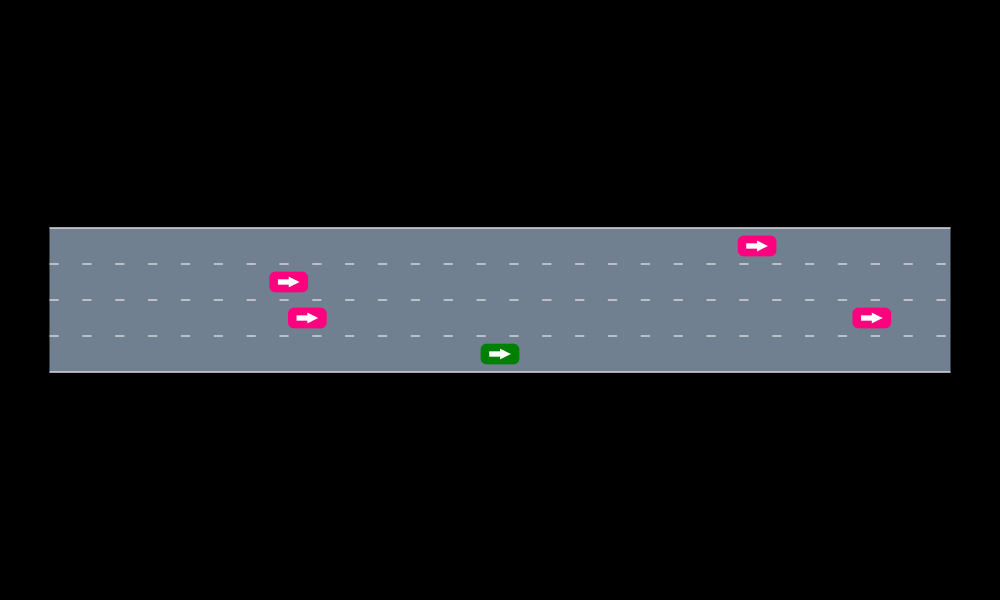

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##300#301{IJulia.#send_stderr,Timer})() at ./event.jl:430
INFO: Reactive event loop was inturrupted.
ERROR (unhandled task failure): InterruptException:


In [30]:
map(drawsim,timestamps)

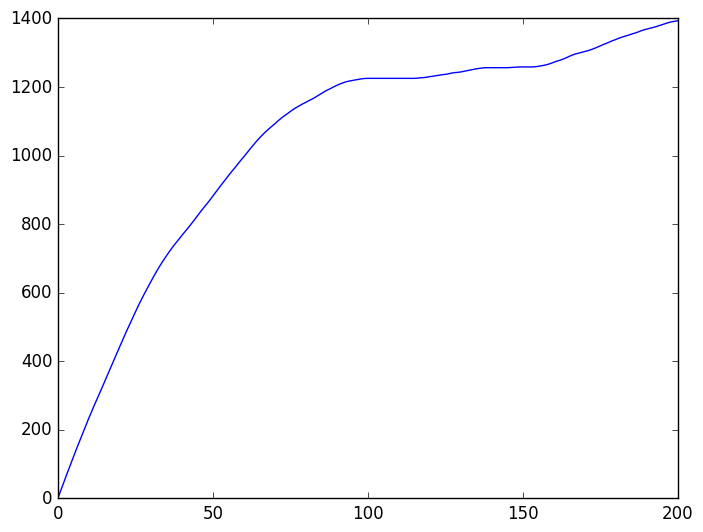

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a22444110>

In [26]:
using PyPlot
state = deepcopy(sim.state_hist);
ex = []
for i = 1:length(state)
    push!(ex,state[i].x)
end
plot(ex)

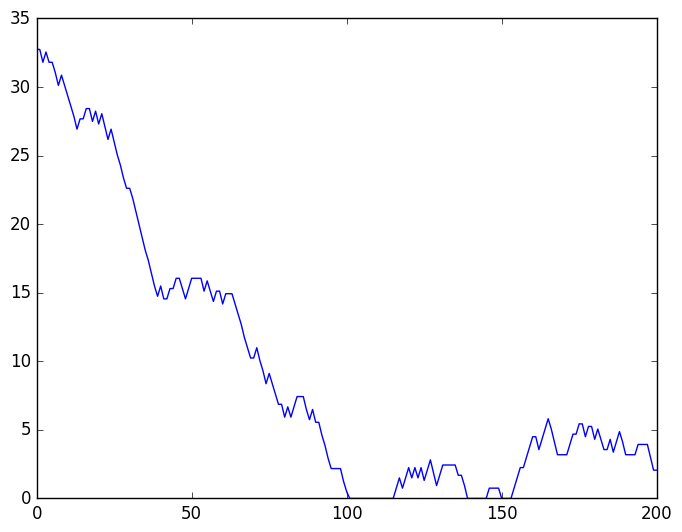

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a2236bd90>

In [27]:
ego_vel = []
for i = 1:length(state)
    push!(ego_vel,state[i].cars[1].vel)
end
plot(ego_vel)